In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv("../eval/fit_ranges/size_increase.csv")
filenames_to_keep = list(df["filename"].unique())
ref_df = pd.read_csv("../pre_results/full_ref_df.csv")
ref_df = ref_df[ref_df["filename"].isin(filenames_to_keep)]
ref_df["size"]=320

df = pd.concat([df,ref_df],sort=False)

df = pd.merge(df,ref_df,on="filename",suffixes=("","_full"))

df["gaba_conc_cr_error"] = df["gaba_conc_cr"] - df["gaba_conc_cr_full"]
df["gaba_conc_cr_abs_error"] = abs(df["gaba_conc_cr_error"])
df["gaba_conc_cr_rel_error"] = df["gaba_conc_cr_error"]/df["gaba_conc_cr_full"]
df["gaba_conc_cr_abs_rel_error"] = abs(df["gaba_conc_cr_rel_error"])

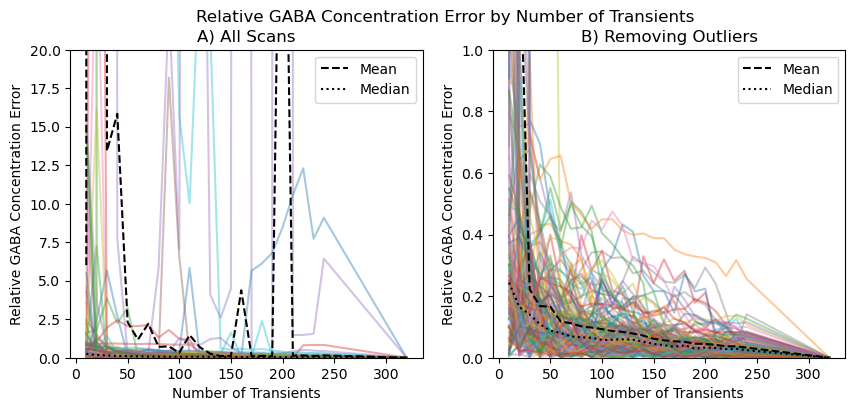

In [79]:
#### Figure 1 - Erro Percentual com Outliers e Sem Outliers

filenames = list(df["filename"].unique())

fig,ax = plt.subplots(1,2,figsize=(10,4))

n_curves = len(filenames)

filtered_filenames=[]

for i in range(n_curves):
    filename=filenames[i]
    i_df = df[df["filename"]==filename].sort_values("size")
    if i_df[i_df["size"]>80]["gaba_conc_cr_abs_rel_error"].max()<0.5:
        filtered_filenames+=[filename]
        ax[1].plot(i_df["size"],i_df["gaba_conc_cr_abs_rel_error"],alpha=0.4)
    ax[0].plot(i_df["size"],i_df["gaba_conc_cr_abs_rel_error"],alpha=0.4)

##ax0 mean and median
mean_df_0 = df.groupby("size").agg({"gaba_conc_cr_abs_rel_error":"mean"}).reset_index()
median_df_0 = df.groupby("size").agg({"gaba_conc_cr_abs_rel_error":"median"}).reset_index()

ax[0].plot(mean_df_0["size"],mean_df_0["gaba_conc_cr_abs_rel_error"],label="Mean",color="k",linestyle="--")
ax[0].plot(median_df_0["size"],median_df_0["gaba_conc_cr_abs_rel_error"],label="Median",color="k",linestyle=":")
ax[0].legend()

mean_df_1 = df[df["filename"].isin(filtered_filenames)].groupby("size").agg({"gaba_conc_cr_abs_rel_error":"mean"}).reset_index()
median_df_1 = df[df["filename"].isin(filtered_filenames)].groupby("size").agg({"gaba_conc_cr_abs_rel_error":"median"}).reset_index()

ax[1].plot(mean_df_1["size"],mean_df_1["gaba_conc_cr_abs_rel_error"],label="Mean",color="k",linestyle="--")
ax[1].plot(median_df_1["size"],median_df_1["gaba_conc_cr_abs_rel_error"],label="Median",color="k",linestyle=":")
ax[1].legend()

for i in range(2):
    ax[i].set_xlabel("Number of Transients")
    ax[i].set_ylabel("Relative GABA Concentration Error")

ax[0].set_title("A) All Scans")
ax[1].set_title("B) Removing Outliers")

fig.suptitle("Relative GABA Concentration Error by Number of Transients")

ax[0].set_ylim(0,20)
ax[1].set_ylim(0,1)
plt.legend()
plt.show()


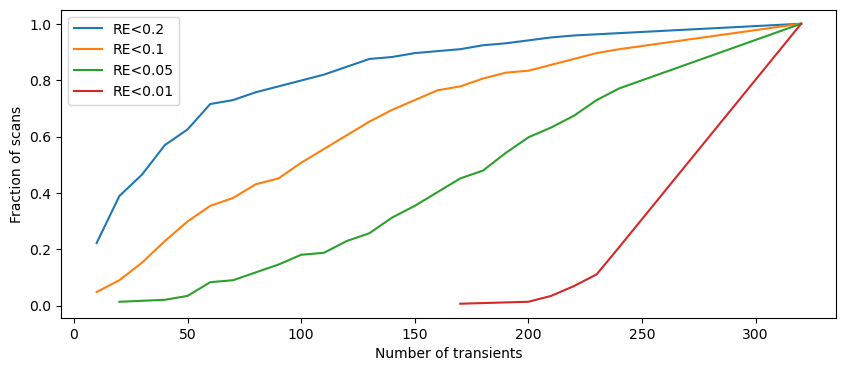

In [12]:
### Figure 2 - How many transients are necessary for achieving error minor then

filenames = list(df["filename"].unique())

fig,ax = plt.subplots(figsize=(10,4))

n_figs = len(filenames)



for tresh in [0.2,0.1,0.05,0.01]:
    out_size=[]
    for i in range(n_figs):
        filename=filenames[i]
        i_df = df[df["filename"]==filename].sort_values("size")
        size_values = i_df["size"].values
        max_size_over_treshold = i_df[i_df["gaba_conc_cr_abs_rel_error"]>=tresh]["size"].max()
        #print(max_size_over_treshold)
        if np.isnan(max_size_over_treshold):
            max_size_over_treshold=0
        elif max_size_over_treshold==240:
            max_size_over_treshold=310
        out_size += [max_size_over_treshold+10]

    out_df = pd.DataFrame({"size":out_size,"count":1})
    out_df = out_df.groupby("size").count().reset_index()
    out_df = out_df.sort_values("size")

    counts = list(out_df["count"])
    i_count=0
    i_counts=[]
    for i in counts:
        i_count+=i
        i_counts.append(i_count)

    #ax.plot(out_df["size"],out_df["count"])
    ax.plot(out_df["size"],np.array(i_counts)/len(filenames_to_keep),label=f"RE<{tresh}")

ax.set_xlabel("Number of transients")
ax.set_ylabel("Fraction of scans")


plt.legend()
plt.show()

In [27]:
### Table - different factors
i_df = df[df["size"].isin([320,240,160,80,40,20])].copy()

i_df = i_df[i_df["gaba_conc_cr_abs_rel_error"]<10]

i_df["re_mean"] = i_df["gaba_conc_cr_abs_rel_error"]
i_df["re_median"] = i_df["gaba_conc_cr_abs_rel_error"]
i_df["re_std"] = i_df["gaba_conc_cr_abs_rel_error"]
i_df["snr_mean"] = i_df["gaba_snr"]
i_df["snr_std"] = i_df["gaba_snr"] 
i_df["fit_mean"] = i_df["gaba_fit_error"]
i_df["fit_std"] = i_df["gaba_fit_error"] 

i_df.groupby("size").agg({"re_mean":"mean","re_std":"std","re_median":"median","snr_mean":"mean","snr_std":"std","fit_mean":"mean","fit_std":"std"})

,re_mean,re_std,re_median,snr_mean,snr_std,fit_mean,fit_std
size,,,,,,,
20,0.353835,0.740015,0.169495,5.945453,3.181979,11.442842,6.814889
40,0.263321,0.728398,0.115739,7.820789,2.553810,9.421705,6.654121
80,0.157818,0.503253,0.068657,11.146921,3.574413,7.048541,4.428882
160,0.062626,0.077419,0.041719,15.820119,5.022437,5.416620,2.701740
240,0.151506,0.923395,0.025501,19.292396,5.860325,4.897985,2.351271
320,0.000000,0.000000,0.000000,22.306480,6.982421,4.650707,2.205503


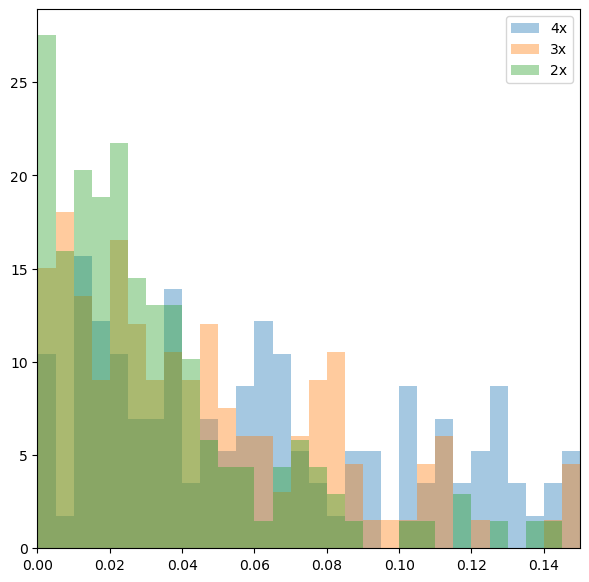

In [96]:
### Figure 2 - Consistency in lower error

i_df_1 = df[df["size"]==80]
i_df_2 = df[df["size"]==160]
i_df_3 = df[df["size"]==240]

fig,ax = plt.subplots(1,figsize=(7,7))

bins = [i*0.005 for i in range(32)]

ax.hist(i_df_1["gaba_conc_cr_abs_rel_error"],bins=bins,alpha=0.4,density=True,label="4x")
ax.hist(i_df_2["gaba_conc_cr_abs_rel_error"],bins=bins,alpha=0.4,density=True,label="3x")
ax.hist(i_df_3["gaba_conc_cr_abs_rel_error"],bins=bins,alpha=0.4,density=True,label="2x")

ax.set_xlim(0,0.15)
#ax.set_ylim(0,0.1)
plt.legend()
plt.show()

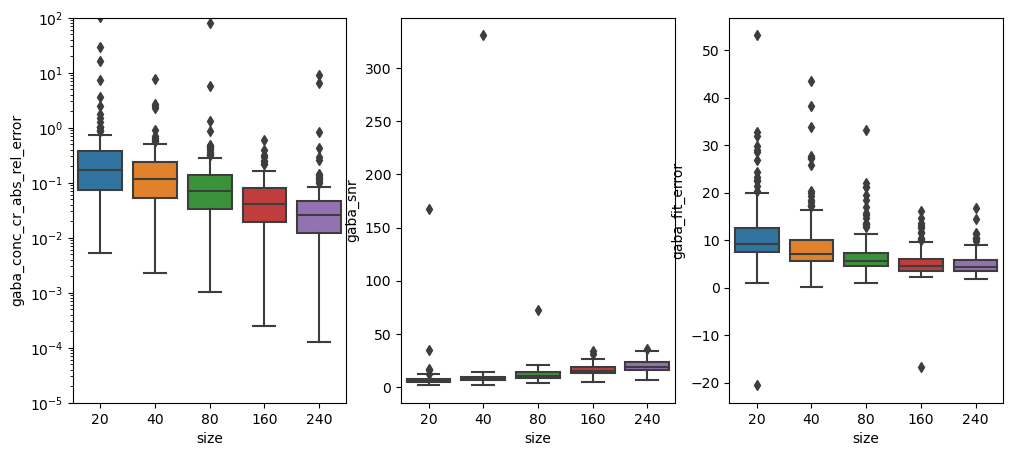

In [10]:
### Figure 3 - Boxplot for different accelerations

i_df_00 = df[df["size"]==20]
i_df_0 = df[df["size"]==40]
i_df_1 = df[df["size"]==80]
i_df_2 = df[df["size"]==160]
i_df_3 = df[df["size"]==240]

i_df = pd.concat([i_df_00,i_df_0,i_df_1,i_df_2,i_df_3],sort=False)

fig,ax = plt.subplots(1,3,figsize=(12,5))

sns.boxplot(i_df,ax=ax[0],x="size",y="gaba_conc_cr_abs_rel_error")
sns.boxplot(i_df,ax=ax[1],x="size",y="gaba_snr")
sns.boxplot(i_df,ax=ax[2],x="size",y="gaba_fit_error")


#ax.set_xlim(0,0.15)
ax[0].set_ylim(0.00001,100)
ax[0].set_yscale("log")
#plt.legend()
plt.show()

In [80]:
print(len(filtered_filenames))

136


g7_s11
g8_s08
g8_s09
g8_s11
p10_s02
p10_s03
p10_s06
p10_s08
p10_s09
p4_s04
p4_s05
p4_s09
p6_s07
p6_s11
s8_s11


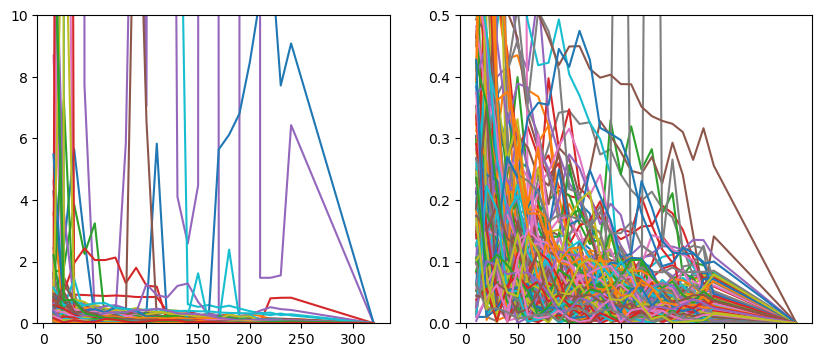

In [55]:
filenames = list(df["filename"].unique())

fig,ax = plt.subplots(1,2,figsize=(10,4))

n_figs = len(filenames)

for i in range(n_figs):
    filename=filenames[i]
    i_df = df[df["filename"]==filename].sort_values("size")
    
    ax[0].plot(i_df["size"],i_df["gaba_conc_cr_abs_error"]/i_df["gaba_conc_cr_full"])
    if i_df["gaba_conc_cr_abs_error"].mean()>0.05:
        print(filename)
    else :
        ax[1].plot(i_df["size"],i_df["gaba_conc_cr_abs_error"]/i_df["gaba_conc_cr_full"])

ax[0].set_ylim(0,10)
ax[1].set_ylim(0,0.5)
plt.show()

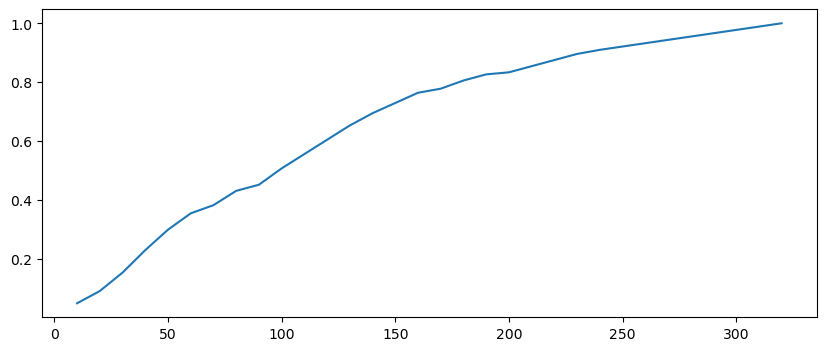

In [50]:
### view how much it needs to have an error smaller than 10%

filenames = list(df["filename"].unique())

fig,ax = plt.subplots(figsize=(10,4))

n_figs = len(filenames)

out_size=[]

for i in range(n_figs):
    filename=filenames[i]
    i_df = df[df["filename"]==filename].sort_values("size")
    size_values = i_df["size"].values
    max_size_over_treshold = i_df[i_df["gaba_conc_cr_abs_rel_error"]>=0.1]["size"].max()
    #print(max_size_over_treshold)
    if np.isnan(max_size_over_treshold):
        max_size_over_treshold=0
    elif max_size_over_treshold==240:
        max_size_over_treshold=310
    out_size += [max_size_over_treshold+10]

out_df = pd.DataFrame({"size":out_size,"count":1})
out_df = out_df.groupby("size").count().reset_index()
out_df = out_df.sort_values("size")

counts = list(out_df["count"])
i_count=0
i_counts=[]
for i in counts:
    i_count+=i
    i_counts.append(i_count)

#ax.plot(out_df["size"],out_df["count"])
ax.plot(out_df["size"],np.array(i_counts)/len(filenames_to_keep))

plt.show()

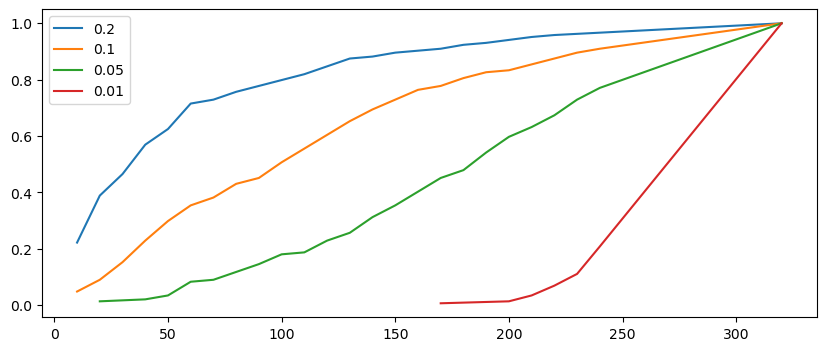

In [53]:
### view how much it needs to have an error smaller than 10%

filenames = list(df["filename"].unique())

fig,ax = plt.subplots(figsize=(10,4))

n_figs = len(filenames)



for tresh in [0.2,0.1,0.05,0.01]:
    out_size=[]
    for i in range(n_figs):
        filename=filenames[i]
        i_df = df[df["filename"]==filename].sort_values("size")
        size_values = i_df["size"].values
        max_size_over_treshold = i_df[i_df["gaba_conc_cr_abs_rel_error"]>=tresh]["size"].max()
        #print(max_size_over_treshold)
        if np.isnan(max_size_over_treshold):
            max_size_over_treshold=0
        elif max_size_over_treshold==240:
            max_size_over_treshold=310
        out_size += [max_size_over_treshold+10]

    out_df = pd.DataFrame({"size":out_size,"count":1})
    out_df = out_df.groupby("size").count().reset_index()
    out_df = out_df.sort_values("size")

    counts = list(out_df["count"])
    i_count=0
    i_counts=[]
    for i in counts:
        i_count+=i
        i_counts.append(i_count)

    #ax.plot(out_df["size"],out_df["count"])
    ax.plot(out_df["size"],np.array(i_counts)/len(filenames_to_keep),label=tresh)

plt.legend()
plt.show()